In [142]:
using Pkg
Pkg.activate("SCC", shared=true)

import SuperconductingCavities as SC

import QuantumToolbox as qt
using Logging
import CairoMakie as cm
cm.activate!(type = "png")
using Makie.Colors
using Makie.GeometryBasics
using Makie

using DifferentialEquations
using MiniLoggers
using ProgressMeter
using LoggingExtras
using Revise
using Dates
using YAXArrays
using DimensionalData

import Optim as OP

using LinearAlgebra
import LsqFit as LF

import Peaks
using Zygote

using JSON3

  Activating project at `~/.julia/environments/SCC`


In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

In [3]:
model = "Mode3"
Model = SC.Circuits.Transmon_Resonators.load("ModelSaves/$(model)/$(model).json");

In [4]:
Model_ManyRamps = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3_ManyRamps/Mode3_ManyRamps.json");

In [5]:
params = []
for ε in collect(LinRange(0.0, Model.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"], 10))
    push!(params, Dict("ε" => ε, "ν" => Model.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"] + Model.Stuff["op_drive_params"]["sb_f0g1"]["shift"]))
end

floq_basis = SC.Dynamics.Floquet_t0_Sweep(Model.hilbertspace, Model.Ô_drive, params, states_to_track=Model.dressed_states);

[2024-12-24 15:08:27] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


[2024-12-24 15:08:42] Info: Done With Floquet Sweep
[2024-12-24 15:08:42] Info: Tracking State
[2024-12-24 15:08:42] Info: Running the necessary time evolutions


# Looking at Ramp Times and Floquet Projections

## Bump Ramp

### Getting Data

In [145]:
ramps = ["Bump_Ramp"]#, "Sine_Squared_Ramp", "Gaussian_Ramp"]

T0 = abs(1/(Model.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Model.Stuff["op_drive_params"]["sb_f0g1"]["shift"]))
ramp_times = collect(2:1:100).*T0

drive_times = 2.0*ramp_times

drives = Dict()
base_drive = deepcopy(Model.Stuff["op_drive_params"]["sb_f0g1"])

op_list = []
for ramp in ramps
    for i in 1:length(ramp_times)
        ramp_time = ramp_times[i]
        drive_time = drive_times[i]
        drive_name = "$(ramp)_$(ramp_time)"
        push!(op_list, drive_name)
        drive = deepcopy(base_drive)
        drive["pulse_time"] = drive_time
        drive["Envelope"] = ramp

        if ramp == "Gaussian_Ramp"
            drive["Envelope Args"] = Dict("pulse_time" => 10*drive_time, "ramp_time" => ramp_time)
        elseif ramp == "Sine_Squared_Ramp"
            drive["Envelope Args"] = Dict("ramp_time" => ramp_time, "pulse_time" => 10*drive_time)
        elseif ramp == "Bump_Ramp"
            drive["Envelope Args"] = Dict("pulse_time" => drive_time*10, "ramp_time" => ramp_time)
        end
        drives[drive_name] = deepcopy(drive)
    end
end

ψ = Model.dressed_states[(2,0)]

res_bump = SC.Dynamics.RunPulseSequence(Model.Ĥ, Model.Ô_drive, ψ, op_list, drives, reset_state = true, spns = "Stroboscopic")


The Name for this run is: Operator_Sequence_Tue-Dec-24-24.21.8
It is being saved at: Data/
[2024-12-24 21:08:03] Info: Running operator Bump_Ramp_0.7061404637619673
[2024-12-24 21:08:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
[2024-12-24 21:08:03] Info: Time Evolution Complete
[2024-12-24 21:08:03] Info: Saving Steps
[2024-12-24 21:08:03] Info: Done with Step_1
[2024-12-24 21:08:03] Info: Running operator Bump_Ramp_1.059210695642951
[2024-12-24 21:08:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
[2024-12-24 21:08:04] Info: Time Evolution Complete
[2024-12-24 21:08:04] Info: Saving Steps
[2024-12-24 21:08:04] Info: Done with Step_2
[2024-12-24 21:08:04] Info: Running operator Bump_Ramp_1.4122809275239345
[2024-12-24 21:08:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Tim

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.35302, 0.70614, 1.05926, 1.41228, 1.76538, 2.11839, 2.47149…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [146]:
mults = round.(Int,drive_times./(T0))

points_to_plot = []
done = 0
for i in mults
    push!(points_to_plot, i+done)
    done += i
end

println(points_to_plot)

floq_basis_dict = Dict{Any, Any}()

for state in keys(Model.dressed_states)
    floq_basis_dict[state] = floq_basis[State = At(string(state)), Step = At(10)]["ψ"]
end

EVs_bump = SC.Utils.Get_EVs(res_bump["states"][points_to_plot], SC.Utils.Get_Projection_Ops(floq_basis_dict))#SC.Utils.Get_Projection_Ops(Model.dressed_states));
times_bump = ramp_times;

Any[4, 10, 18, 28, 40, 54, 70, 88, 108, 130, 154, 180, 208, 238, 270, 304, 340, 378, 418, 460, 504, 550, 598, 648, 700, 754, 810, 868, 928, 990, 1054, 1120, 1188, 1258, 1330, 1404, 1480, 1558, 1638, 1720, 1804, 1890, 1978, 2068, 2160, 2254, 2350, 2448, 2548, 2650, 2754, 2860, 2968, 3078, 3190, 3304, 3420, 3538, 3658, 3780, 3904, 4030, 4158, 4288, 4420, 4554, 4690, 4828, 4968, 5110, 5254, 5400, 5548, 5698, 5850, 6004, 6160, 6318, 6478, 6640, 6804, 6970, 7138, 7308, 7480, 7654, 7830, 8008, 8188, 8370, 8554, 8740, 8928, 9118, 9310, 9504, 9700, 9898, 10098]


### Making Plot

[2024-12-24 21:11:41] Info: Making Plot


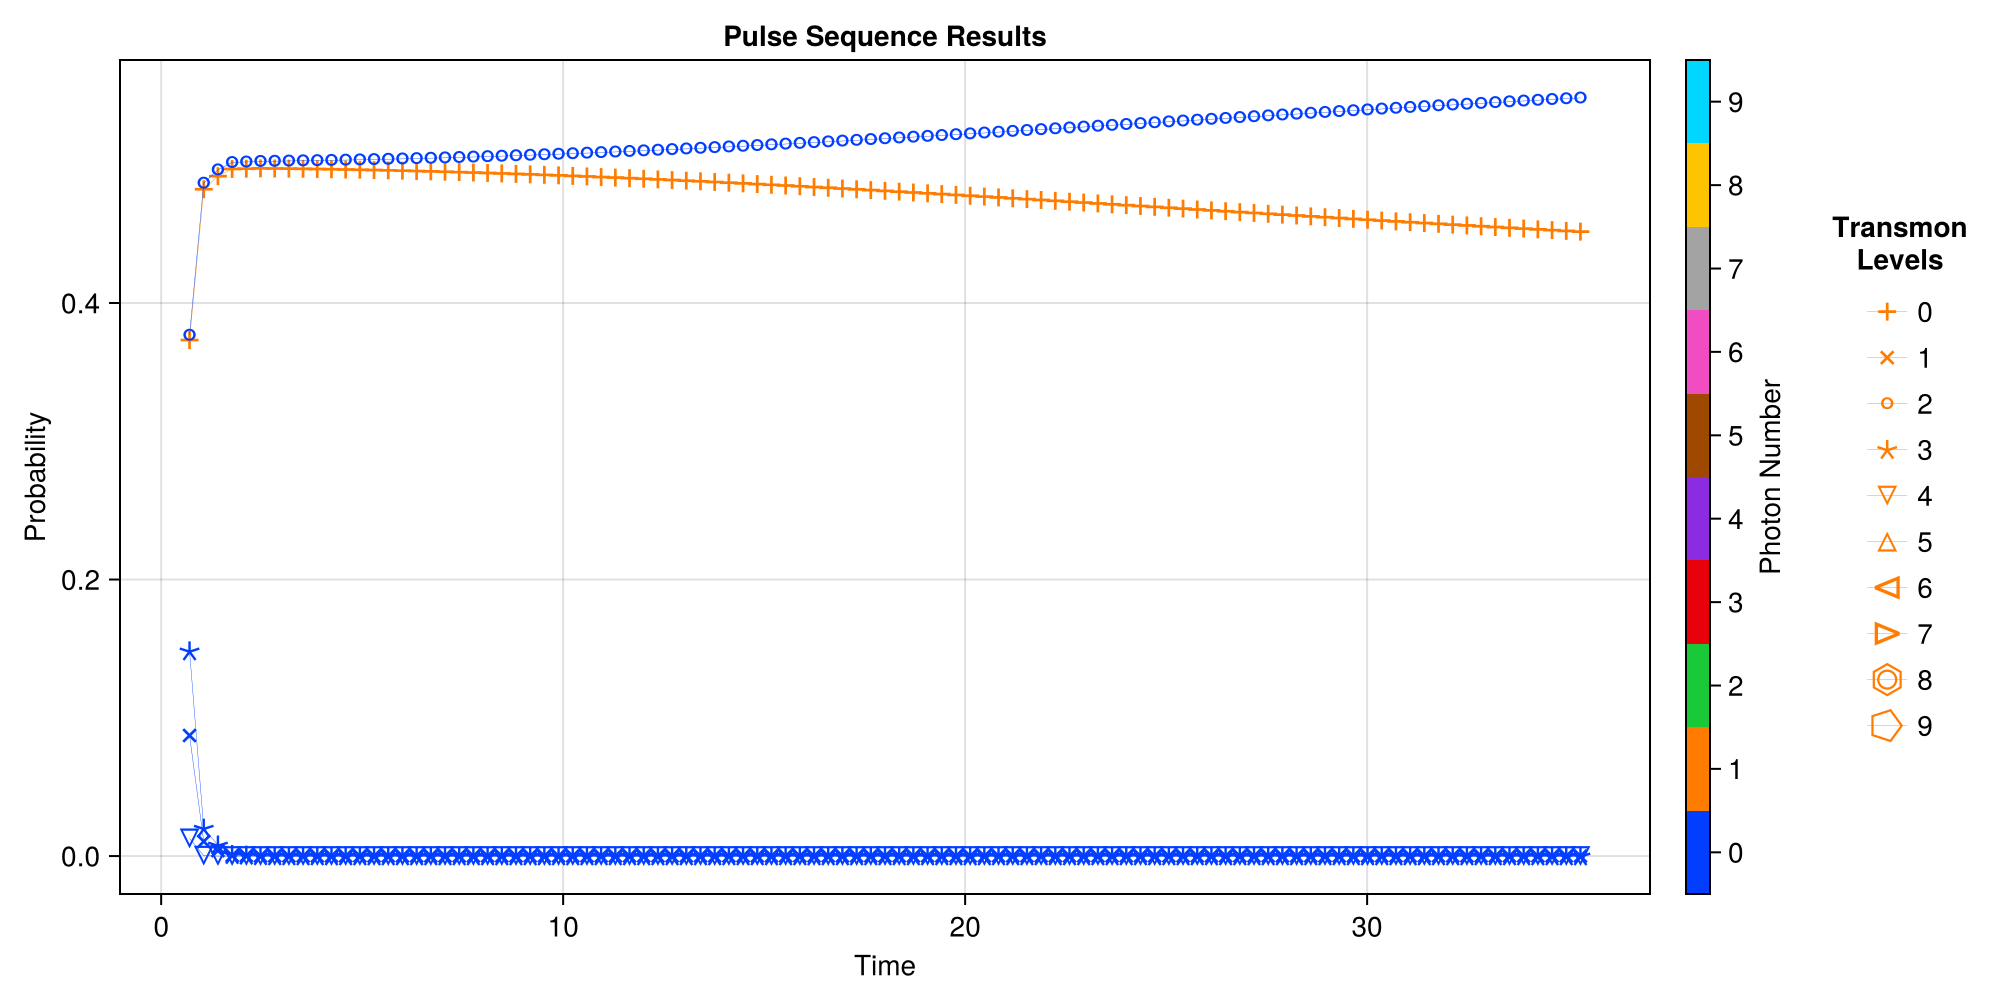

CairoMakie.Screen{IMAGE}


In [147]:
SC.Dynamics.PlotSingleModeEvolution(Model, times_bump, EVs_bump)

In [148]:
EVs_bump[(2,0)][1]+EVs_bump[(0,1)][1]

0.7500035970604093 - 3.1541411879841394e-18im

## Sine Squared Ramp

### Getting Data

In [149]:
ramps = ["Sine_Squared_Ramp"]#, "Sine_Squared_Ramp", "Gaussian_Ramp"]

T0 = abs(1/(Model.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Model.Stuff["op_drive_params"]["sb_f0g1"]["shift"]))
ramp_times = collect(2:1:100).*T0

drive_times = 2.0*ramp_times

drives = Dict()
base_drive = deepcopy(Model.Stuff["op_drive_params"]["sb_f0g1"])

op_list = []
for ramp in ramps
    for i in 1:length(ramp_times)
        ramp_time = ramp_times[i]
        drive_time = drive_times[i]
        drive_name = "$(ramp)_$(ramp_time)"
        push!(op_list, drive_name)
        drive = deepcopy(base_drive)
        drive["pulse_time"] = drive_time
        drive["Envelope"] = ramp

        if ramp == "Gaussian_Ramp"
            drive["Envelope Args"] = Dict("pulse_time" => 10*drive_time, "ramp_time" => ramp_time)
        elseif ramp == "Sine_Squared_Ramp"
            drive["Envelope Args"] = Dict("ramp_time" => ramp_time, "pulse_time" => 10*drive_time)
        elseif ramp == "Bump_Ramp"
            drive["Envelope Args"] = Dict("pulse_time" => drive_time*10, "ramp_time" => ramp_time)
        end
        drives[drive_name] = deepcopy(drive)
    end
end

ψ = Model.dressed_states[(2,0)]

res_ss = SC.Dynamics.RunPulseSequence(Model.Ĥ, Model.Ô_drive, ψ, op_list, drives, reset_state = true, spns = "Stroboscopic")


The Name for this run is: Operator_Sequence_Tue-Dec-24-24.21.11
It is being saved at: Data/
[2024-12-24 21:11:41] Info: Running operator Sine_Squared_Ramp_0.7061404637619673
[2024-12-24 21:11:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
[2024-12-24 21:11:41] Info: Time Evolution Complete
[2024-12-24 21:11:41] Info: Saving Steps
[2024-12-24 21:11:42] Info: Done with Step_1
[2024-12-24 21:11:42] Info: Running operator Sine_Squared_Ramp_1.059210695642951
[2024-12-24 21:11:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
[2024-12-24 21:11:42] Info: Time Evolution Complete
[2024-12-24 21:11:42] Info: Saving Steps
[2024-12-24 21:11:42] Info: Done with Step_2
[2024-12-24 21:11:42] Info: Running operator Sine_Squared_Ramp_1.4122809275239345
[2024-12-24 21:11:42] Info: Running Time Evolution
Progress: [=============================

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.35302, 0.70614, 1.05926, 1.41228, 1.76538, 2.11839, 2.47149…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [150]:
mults = round.(Int,drive_times./(T0))

points_to_plot = []
done = 0
for i in mults
    push!(points_to_plot, i+done)
    done += i
end

println(points_to_plot)

floq_basis_dict = Dict{Any, Any}()

for state in keys(Model.dressed_states)
    floq_basis_dict[state] = floq_basis[State = At(string(state)), Step = At(10)]["ψ"]
end

EVs_ss = SC.Utils.Get_EVs(res_ss["states"][points_to_plot], SC.Utils.Get_Projection_Ops(floq_basis_dict))#SC.Utils.Get_Projection_Ops(Model.dressed_states));
times_ss = ramp_times;

Any[4, 10, 18, 28, 40, 54, 70, 88, 108, 130, 154, 180, 208, 238, 270, 304, 340, 378, 418, 460, 504, 550, 598, 648, 700, 754, 810, 868, 928, 990, 1054, 1120, 1188, 1258, 1330, 1404, 1480, 1558, 1638, 1720, 1804, 1890, 1978, 2068, 2160, 2254, 2350, 2448, 2548, 2650, 2754, 2860, 2968, 3078, 3190, 3304, 3420, 3538, 3658, 3780, 3904, 4030, 4158, 4288, 4420, 4554, 4690, 4828, 4968, 5110, 5254, 5400, 5548, 5698, 5850, 6004, 6160, 6318, 6478, 6640, 6804, 6970, 7138, 7308, 7480, 7654, 7830, 8008, 8188, 8370, 8554, 8740, 8928, 9118, 9310, 9504, 9700, 9898, 10098]


### Making Plot

[2024-12-24 21:14:45] Info: Making Plot


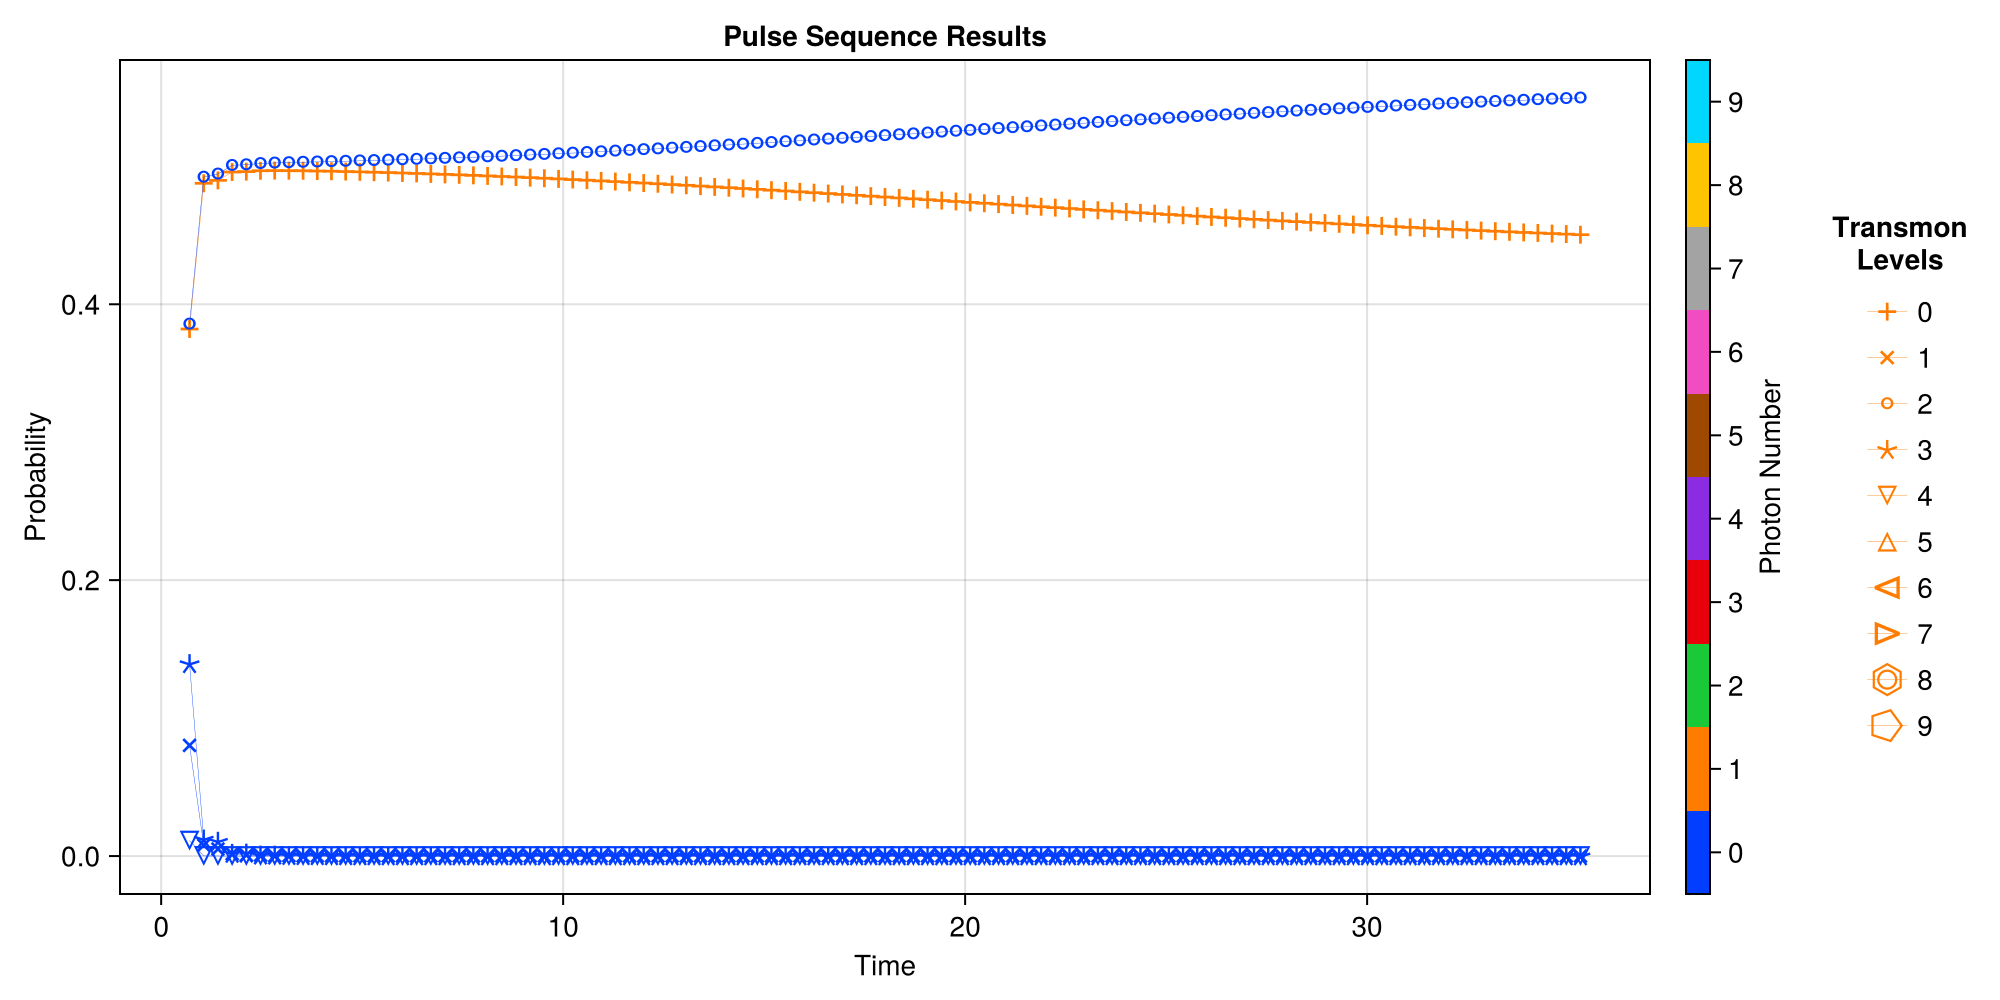

CairoMakie.Screen{IMAGE}


In [151]:
SC.Dynamics.PlotSingleModeEvolution(Model, times_ss, EVs_ss)

## Gaussian Ramp

### Getting Data

In [152]:
ramps = ["Gaussian_Ramp"]#, "Sine_Squared_Ramp", "Gaussian_Ramp"]

T0 = abs(1/(Model.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Model.Stuff["op_drive_params"]["sb_f0g1"]["shift"]))
ramp_times = collect(2:1:100).*T0

drive_times = 2.0*ramp_times

drives = Dict()
base_drive = deepcopy(Model.Stuff["op_drive_params"]["sb_f0g1"])

op_list = []
for ramp in ramps
    for i in 1:length(ramp_times)
        ramp_time = ramp_times[i]
        drive_time = drive_times[i]
        drive_name = "$(ramp)_$(ramp_time)"
        push!(op_list, drive_name)
        drive = deepcopy(base_drive)
        drive["pulse_time"] = drive_time
        drive["Envelope"] = ramp

        if ramp == "Gaussian_Ramp"
            drive["Envelope Args"] = Dict("pulse_time" => 10*drive_time, "ramp_time" => ramp_time)
        elseif ramp == "Sine_Squared_Ramp"
            drive["Envelope Args"] = Dict("ramp_time" => ramp_time, "pulse_time" => 10*drive_time)
        elseif ramp == "Bump_Ramp"
            drive["Envelope Args"] = Dict("pulse_time" => drive_time*10, "ramp_time" => ramp_time)
        end
        drives[drive_name] = deepcopy(drive)
    end
end

ψ = Model.dressed_states[(2,0)]

res_g = SC.Dynamics.RunPulseSequence(Model.Ĥ, Model.Ô_drive, ψ, op_list, drives, reset_state = true, spns = "Stroboscopic")


The Name for this run is: Operator_Sequence_Tue-Dec-24-24.21.14
It is being saved at: Data/
[2024-12-24 21:14:45] Info: Running operator Gaussian_Ramp_0.7061404637619673
[2024-12-24 21:14:45] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
[2024-12-24 21:14:45] Info: Time Evolution Complete
[2024-12-24 21:14:45] Info: Saving Steps
[2024-12-24 21:14:46] Info: Done with Step_1
[2024-12-24 21:14:46] Info: Running operator Gaussian_Ramp_1.059210695642951
[2024-12-24 21:14:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
[2024-12-24 21:14:46] Info: Time Evolution Complete
[2024-12-24 21:14:46] Info: Saving Steps
[2024-12-24 21:14:46] Info: Done with Step_2
[2024-12-24 21:14:46] Info: Running operator Gaussian_Ramp_1.4122809275239345
[2024-12-24 21:14:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.35302, 0.70614, 1.05926, 1.41228, 1.76538, 2.11839, 2.47149…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [153]:
mults = round.(Int,drive_times./(T0))

points_to_plot = []
done = 0
for i in mults
    push!(points_to_plot, i+done)
    done += i
end

println(points_to_plot)

floq_basis_dict = Dict{Any, Any}()

for state in keys(Model.dressed_states)
    floq_basis_dict[state] = floq_basis[State = At(string(state)), Step = At(10)]["ψ"]
end

EVs_g = SC.Utils.Get_EVs(res_g["states"][points_to_plot], SC.Utils.Get_Projection_Ops(floq_basis_dict))#SC.Utils.Get_Projection_Ops(Model.dressed_states));
times_g = ramp_times;

Any[4, 10, 18, 28, 40, 54, 70, 88, 108, 130, 154, 180, 208, 238, 270, 304, 340, 378, 418, 460, 504, 550, 598, 648, 700, 754, 810, 868, 928, 990, 1054, 1120, 1188, 1258, 1330, 1404, 1480, 1558, 1638, 1720, 1804, 1890, 1978, 2068, 2160, 2254, 2350, 2448, 2548, 2650, 2754, 2860, 2968, 3078, 3190, 3304, 3420, 3538, 3658, 3780, 3904, 4030, 4158, 4288, 4420, 4554, 4690, 4828, 4968, 5110, 5254, 5400, 5548, 5698, 5850, 6004, 6160, 6318, 6478, 6640, 6804, 6970, 7138, 7308, 7480, 7654, 7830, 8008, 8188, 8370, 8554, 8740, 8928, 9118, 9310, 9504, 9700, 9898, 10098]


### Making Plot

[2024-12-24 21:17:47] Info: Making Plot


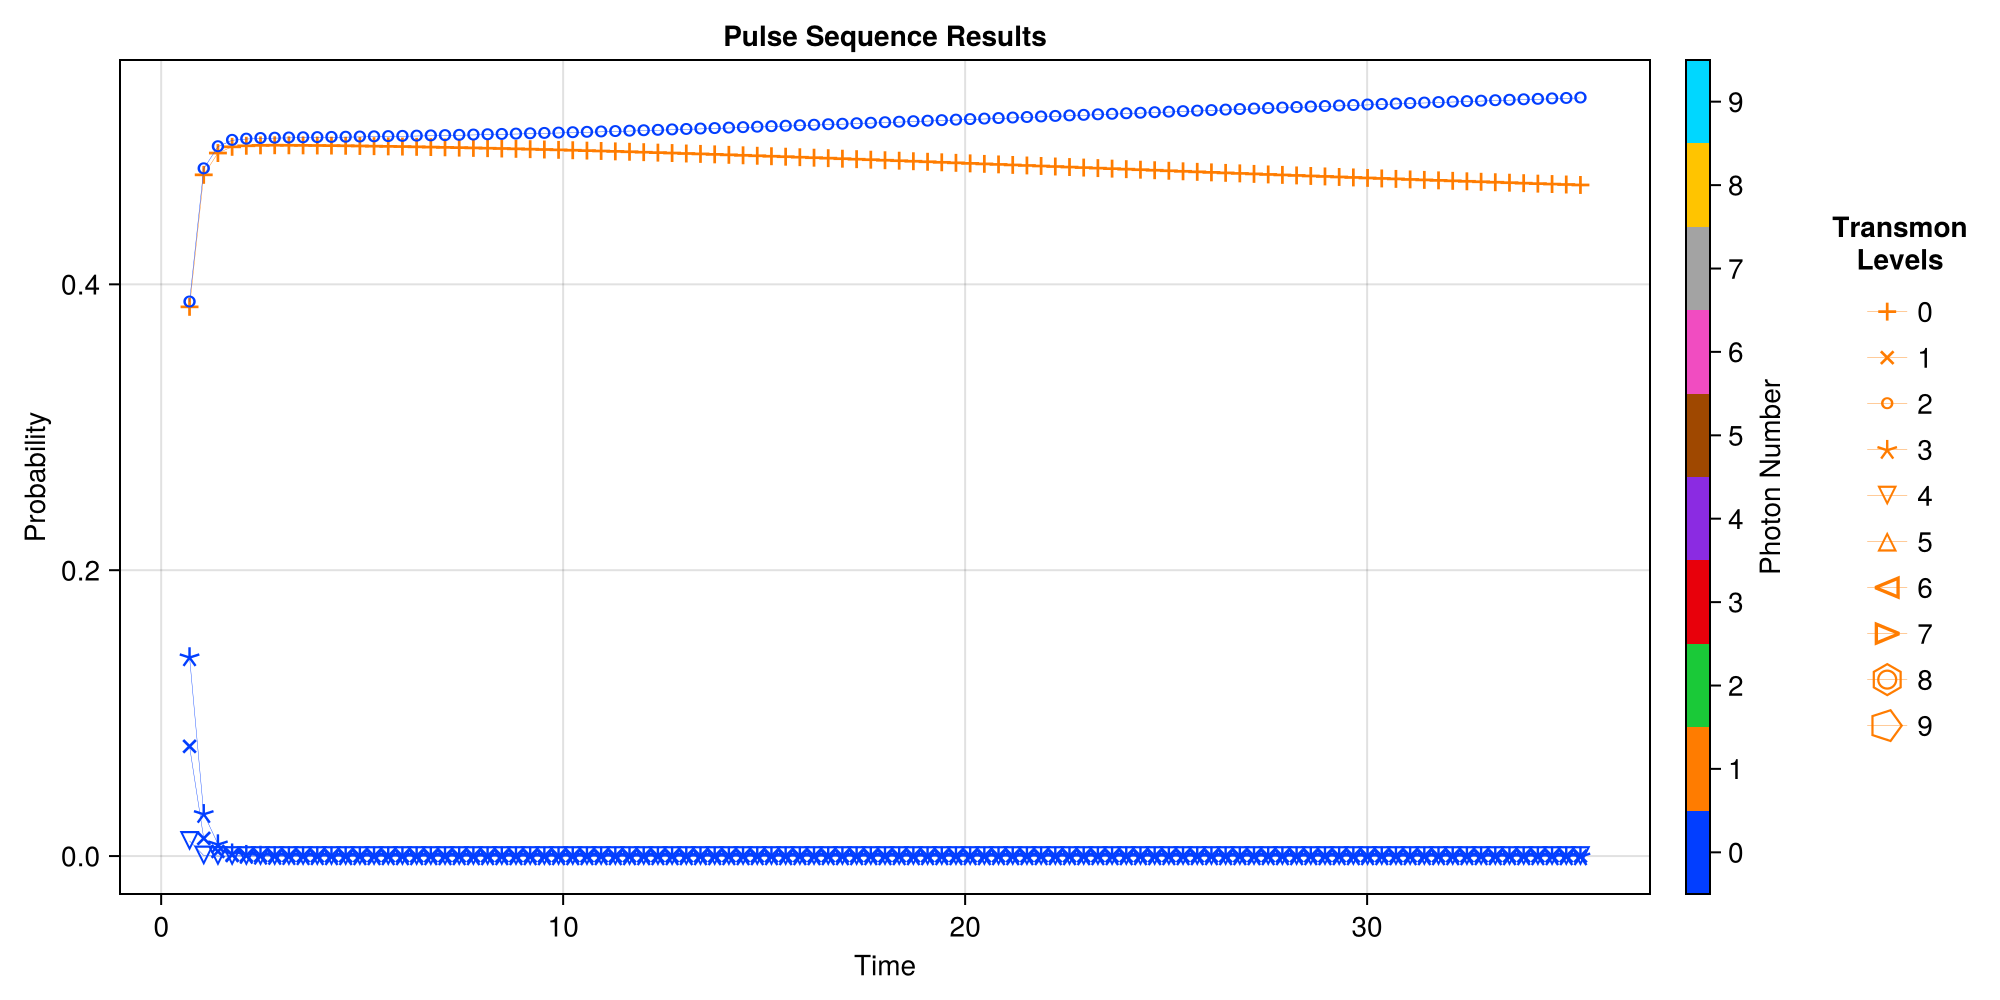

CairoMakie.Screen{IMAGE}


In [154]:
SC.Dynamics.PlotSingleModeEvolution(Model, times_g, EVs_g)

## Saving Data

In [155]:
EVs_bump_ts = Dict{Any, Any}()
EVs_ss_ts = Dict{Any, Any}()
EVs_g_ts = Dict{Any, Any}()

for key in collect(keys(EVs_bump))
    EVs_bump_ts[key] = real.(EVs_bump[key])
    EVs_ss_ts[key] = real.(EVs_ss[key])
    EVs_g_ts[key] = real.(EVs_g[key])
end

In [156]:
dat_dict = Dict("Bump" => Dict("times" => times_bump, "EVs" => (EVs_bump_ts)), "Sine_Squared" => Dict("times" => times_ss, "EVs" => (EVs_ss_ts)), "Gaussian" => Dict("times" => times_g, "EVs" => (EVs_g_ts)))

Dict{String, Dict{String, Any}} with 3 entries:
  "Sine_Squared" => Dict("EVs"=>Dict{Any, Any}((7, 1)=>[3.26268e-8, 2.53611e-10…
  "Gaussian"     => Dict("EVs"=>Dict{Any, Any}((7, 1)=>[2.79369e-8, 1.30995e-10…
  "Bump"         => Dict("EVs"=>Dict{Any, Any}((7, 1)=>[3.92853e-8, 5.50518e-10…

In [157]:
open("Data/Ramps.json","w") do f
   JSON3.pretty(f, dat_dict)
end

[2024-12-26 13:37:02] Error: Error watching manifest exception = MethodError: no method matching (::OpenSSL_jll.var"#make_wrapper_dict#6"{OpenSSL_jll.var"#parse_wrapper_platform#5"})(::String, ::Vector{String})
The function `make_wrapper_dict` exists, but no method is defined for this combination of argument types.
Stacktrace:
 [1] top-level scope
   @ ~/.julia/packages/JLLWrappers/jXOYx/src/toplevel_generators.jl:160
Revise evaluation error at /Users/gavinrockwood/.julia/packages/JLLWrappers/jXOYx/src/toplevel_generators.jl:160

Stacktrace:
 [1] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::@Kwargs{})
   @ Revise ~/.julia/packages/Revise/vhmOR/src/lowered.jl:284


## Big Plot

In [18]:
greens = [colorant"#1B5E20", colorant"#388E3C", colorant"#66BB6A", colorant"#C8E6C9"] # Green
oranges = [colorant"#FF6F00", colorant"#FFA000", colorant"#FFCA28", colorant"#FFECB3"] # Orange 
#colors2 = [colorant"#FF6F00", colorant"#FFA000", colorant"#FFEB3B", colorant"#FFE082"] # Orange
blues = [colorant"#1A237E", colorant"#1976D2", colorant"#03A9F4", colorant"#90CAF9"] # Blue
reds = [colorant"#880E4F", colorant"#D81B60", colorant"#F06292", colorant"#F8BBD0"] # Red
purples = [colorant"#4A148C", colorant"#7B1FA2", colorant"#AB47BC", colorant"#E1BEE7"] # Purple

colors = hcat(greens, oranges, blues, reds, purples)

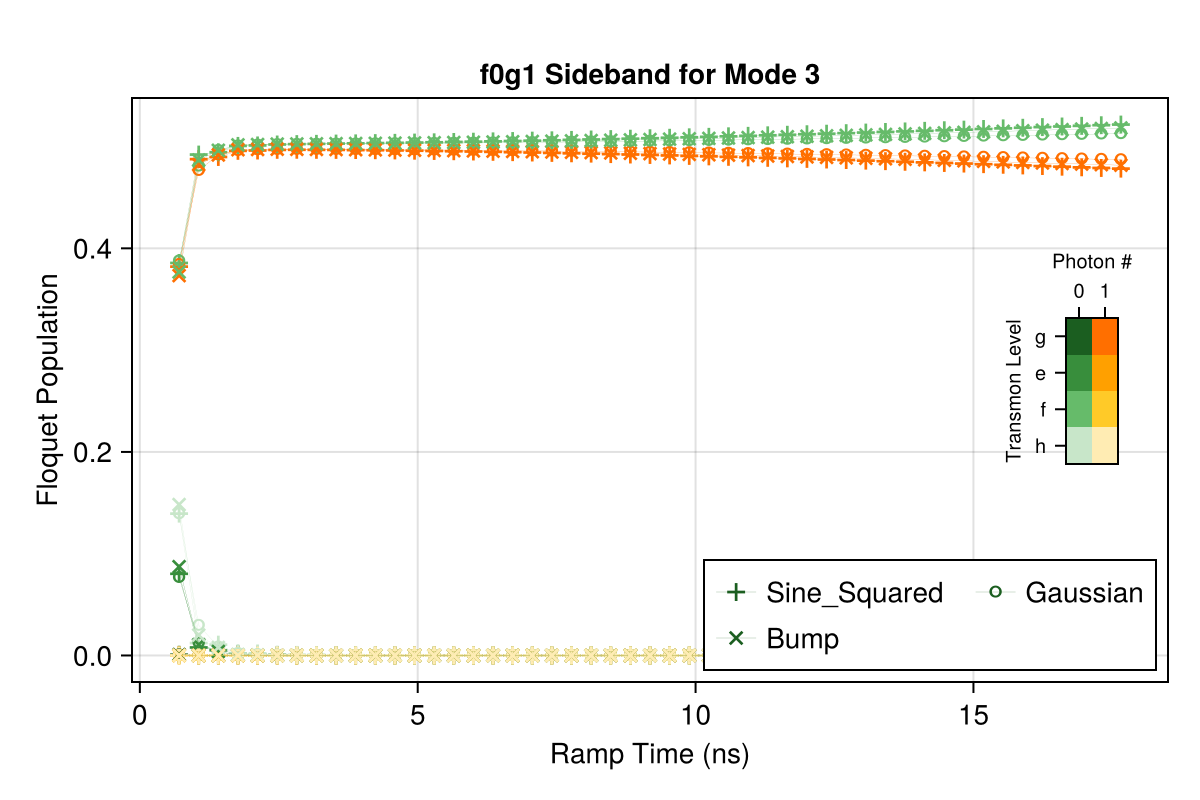

CairoMakie.Screen{IMAGE}


In [19]:
figsize = (600, 400)
fig = cm.Figure(size = figsize, px_per_unit = 10)

tlevels = [0,1,2,3]
clevels = [0,1]

main_ax = cm.Axis(fig[1,1], title = "f0g1 Sideband for Mode 3", xlabel = "Ramp Time (ns)", ylabel = "Floquet Population")

line_styles = Dict("Bump" => :solid, "Sine_Squared" => :dash, "Gaussian" => :dot)
markers = Dict("Bump" => '×', "Sine_Squared" => '+', "Gaussian" => '∘')

for key in keys(dat_dict)
    for pair in Iterators.product(clevels, tlevels)
        label = "|$(pair[2]), $(pair[1])⟩ "
        color = colors[pair[2]+1,pair[1]+1]

        x = dat_dict[key]["times"][1:1:end]
        y = real.(dat_dict[key]["EVs"][(pair[2],pair[1])])[1:1:end]
        #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
        if pair == (0,0)
            label = key
        else
            label = nothing
        end
        cm.scatterlines!(main_ax, x,y, color = color, linewidth = 0.1, alpha = 0.9, marker = markers[key], markersize = 20, label = label)
        #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
        
    end
end
#cm.Legend(fig[1,2], main_ax, nbanks = 1)
#cm.axislegend(main_ax, position = :rc, nbanks = 2)
w_rel = 0.05
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.95,
                    valign = 0.5,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([1,2], ["0", "1"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(cm.to_color(colors), (2,1))[1:2, end:-1:1]
cm.heatmap!(legend_ax, z)


cm.axislegend(main_ax, position = :rb, nbanks = 2)


#cm.save("figures/f0g1SidebandSubStrobSampling.png", fig, px_per_unit = 10)
display(fig)

In [56]:
test = "f0g1_B_13.769739043358362"

rts = []
for key in keys(Model_ManyRamps.Stuff["op_drive_params"])
    if split(key, "_")[1] == "f0g1"
        if split(key, "_")[2] == "B"
            push!(rts, split(key, "_")[3])
        end
    end
end

rts = sort(rts, by = x -> parse(Float64, x))

49-element Vector{Any}:
 "0.7061404637619673"
 "1.059210695642951"
 "1.4122809275239345"
 "1.765351159404918"
 "2.118421391285902"
 "2.4714916231668855"
 "2.824561855047869"
 "3.1776320869288526"
 "3.530702318809836"
 "3.88377255069082"
 "4.236842782571804"
 "4.5899130144527875"
 "4.942983246333771"
 ⋮
 "13.769739043358362"
 "14.122809275239344"
 "14.475879507120329"
 "14.828949739001313"
 "15.182019970882296"
 "15.53509020276328"
 "15.888160434644263"
 "16.241230666525247"
 "16.59430089840623"
 "16.947371130287216"
 "17.300441362168197"
 "17.65351159404918"

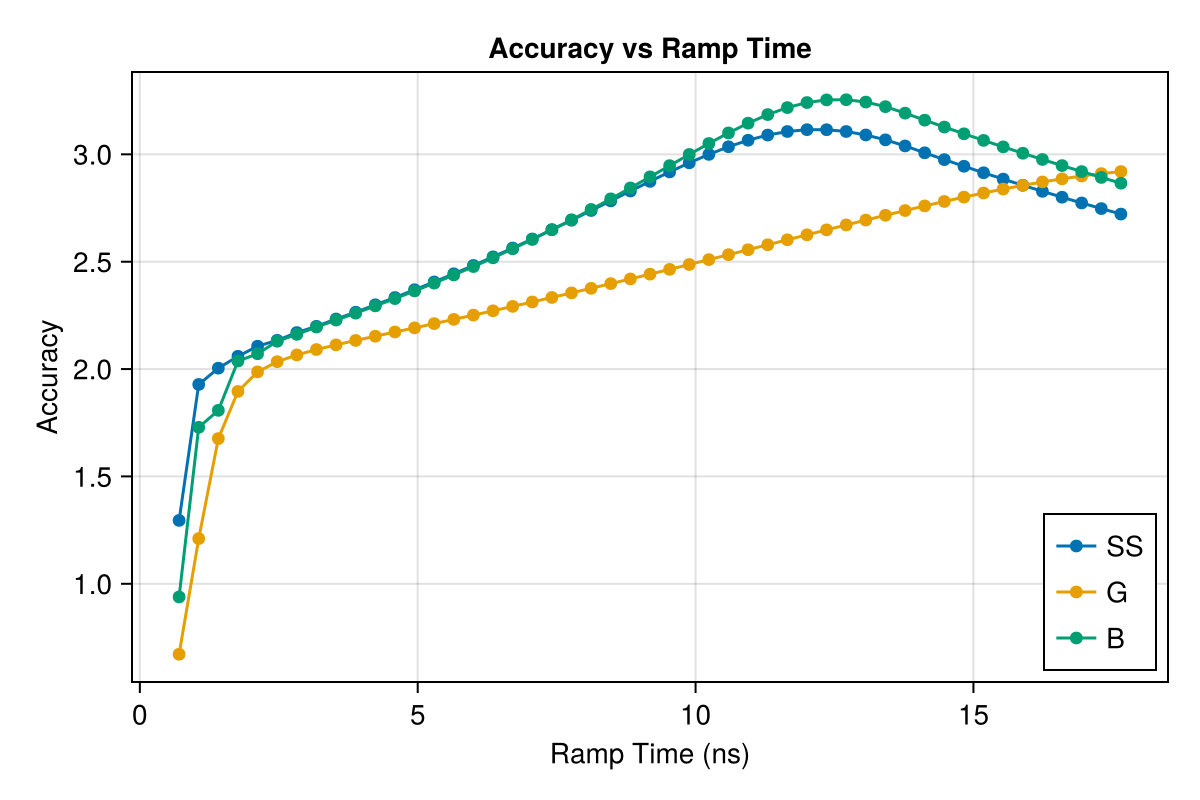

CairoMakie.Screen{IMAGE}


In [58]:
fig = cm.Figure(size = (600, 400))
ax = cm.Axis(fig[1,1], title = "Accuracy vs Ramp Time", xlabel = "Ramp Time (ns)", ylabel = "Accuracy")
for ramp in ["SS", "G", "B"]
    x = []
    y = []
    for rt in rts
        push!(x, parse(Float64, rt))
        push!(y, Model_ManyRamps.Stuff["op_drive_params"]["f0g1_$(ramp)_$(rt)"]["accuracy"])
    end
    cm.scatterlines!(ax, x,-log10.(1.0.-y), label = ramp)
end

cm.axislegend(ax, position = :rb)
display(fig)

## Doing Fits

In [111]:
function fidelity_func(θ, ψ)
    ψ_for_ρ = (ψf0+exp(-1im*π*θ[1])*ψg1)/sqrt(2)
    ρ = ψ_for_ρ*ψ_for_ρ'
    return abs(qt.expect(ρ, ψ))
end

ψf0 = floq_basis[State = At(string((2,0))), Step = At(10)]["ψ"];
ψg1 = floq_basis[State = At(string((0,1))), Step = At(10)]["ψ"];


In [116]:
fits_G = []
for ψ in res_g["states"][points_to_plot]
    to_minimize(θ) = abs(1-fidelity_func(θ, ψ))
    op_res = OP.optimize(to_minimize, [0.0])
    push!(fits_G,  1-OP.minimum(op_res))
end

fits_SS = []
for ψ in res_ss["states"][points_to_plot]
    to_minimize(θ) = abs(1-fidelity_func(θ, ψ))
    op_res = OP.optimize(to_minimize, [0.0])
    push!(fits_SS,  1-OP.minimum(op_res))
end

fits_B = []
for ψ in res_bump["states"][points_to_plot]
    to_minimize(θ) = abs(1-fidelity_func(θ, ψ))
    op_res = OP.optimize(to_minimize, [0.0])
    push!(fits_B,  1-OP.minimum(op_res))
end

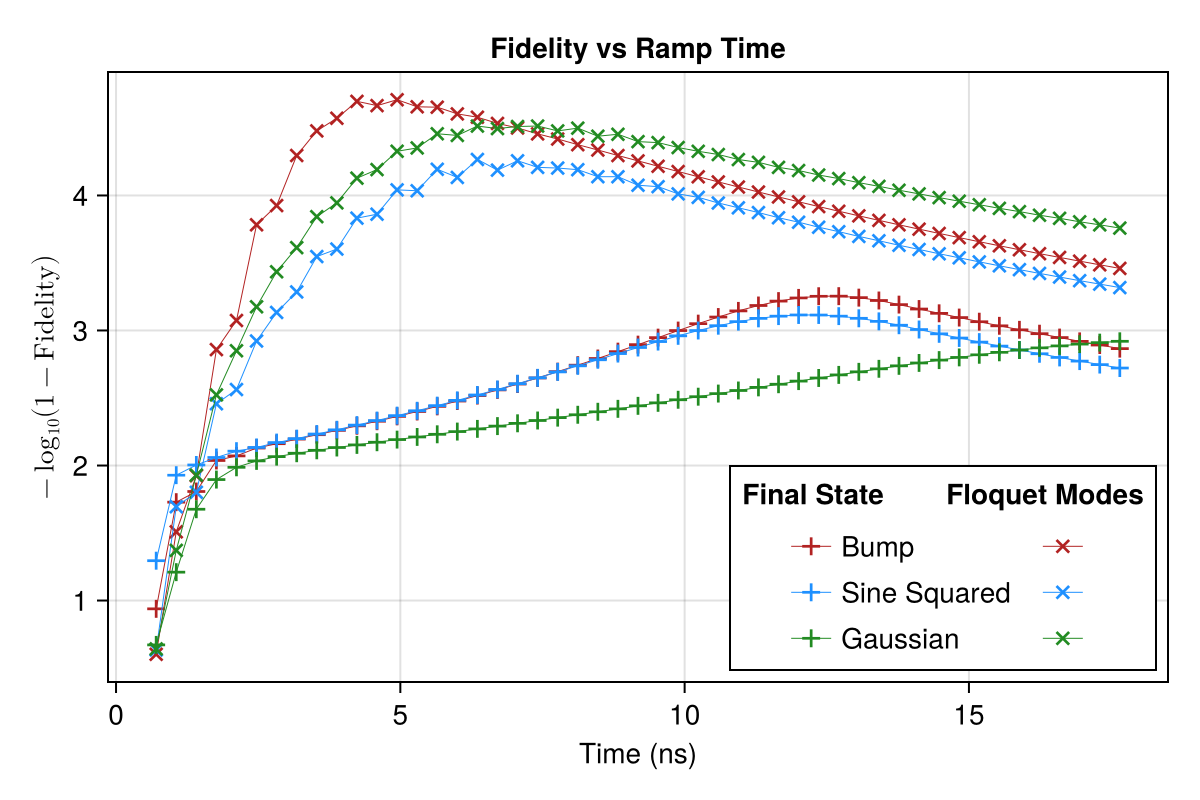

CairoMakie.Screen{IMAGE}


In [144]:
fig = cm.Figure(size = (600, 400))
ax = cm.Axis(fig[1,1], title = "Fidelity vs Ramp Time", xlabel = "Time (ns)", ylabel = L"-\log_{10}\left(1-\text{Fidelity}\right)")


colors = Dict("G" => "forestgreen", "SS" => "dodgerblue", "B" => "firebrick")
x = []
y = []
for rt in rts
    push!(x, parse(Float64, rt))
    push!(y, Model_ManyRamps.Stuff["op_drive_params"]["f0g1_B_$(rt)"]["accuracy"])
end
cm.scatterlines!(ax, x,-log10.(1.0.-y), label = "Bump", color = colors["B"], marker = '+', linewidth = 0.5, markersize = 20)
cm.scatterlines!(ax, times_bump, -log10.(1.0.-fits_B), label = "", color = colors["B"], marker = '×', linewidth = 0.5, markersize = 20)

x = []
y = []
for rt in rts
    push!(x, parse(Float64, rt))
    push!(y, Model_ManyRamps.Stuff["op_drive_params"]["f0g1_SS_$(rt)"]["accuracy"])
end
cm.scatterlines!(ax, x,-log10.(1.0.-y), label = "Sine Squared", color = colors["SS"], marker = '+', linewidth = 0.5, markersize = 20)
cm.scatterlines!(ax, times_ss, -log10.(1.0.-fits_SS), label = "", color = colors["SS"], marker = '×', linewidth = 0.5, markersize = 20)

x = []
y = []
for rt in rts
    push!(x, parse(Float64, rt))
    push!(y, Model_ManyRamps.Stuff["op_drive_params"]["f0g1_G_$(rt)"]["accuracy"])
end
cm.scatterlines!(ax, x,-log10.(1.0.-y), label = "Gaussian", color = colors["G"], marker = '+', linewidth = 0.5, markersize = 20)
cm.scatterlines!(ax, times_g, -log10.(1.0.-fits_G), label = "", color = colors["G"], marker = '×', linewidth = 0.5, markersize = 20)

cm.axislegend(ax, "Final State        Floquet Modes", position = :rb, nbanks = 2)

display(fig)